<a href="https://colab.research.google.com/github/restrepo/COVID-19/blob/master/explore/covid_real_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 data for Colombia: Real time, 

Use of [public Covid-19 in GitHub](https://github.com/CSSEGISandData/COVID-19) data from: 
[Center for Systems Science and Engineering (CSSE)](https://systems.jhu.edu/):

* Hongru Du, Lauren Gardner, and Ensheng Dong, An interactive web-based dashboard to track COVID-19 in real time, http://www.thelancet.com/infection Published:February 19, 2020, DOI:https://doi.org/10.1016/S1473-3099(20)30120-1

For examples of use of the data see Jupyter Notebook `covid19_analysis.ipynb`: [[local](./covid19_analysis.ipynb)] [[GitHub](https://github.com/restrepo/Covid-19/blob/master/covid_analysis.ipynb)] [[Colab](https://colab.research.google.com/github/restrepo/Covid-19/blob/master/covid_analysis.ipynb)]

[Official Colombia data](https://infogram.com/covid-2019-ins-colombia-1hnq41zg9ord63z)

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import re
#See https://strftime.org/
import datetime
import numpy as np
from scipy import optimize as opt
import time
import os

In [3]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

def RO(td,γ=1./5.7,μ=1/(70*365)):
    return 1+np.log(2)/(td*(μ+γ))    
    
def date_range(date_start='2/23/20',date_end='3/03/20',date_step=1,
               strptime_format="%m/%d/%y",
               strftime_format="%-m/%-d/%y"):
    dr=[]
    start = datetime.datetime.strptime(date_start,strptime_format )
    end = datetime.datetime.strptime(date_end,strptime_format)
    step = datetime.timedelta(days=date_step)
    while start <= end:
        #avoid leading zeroes: https://stackoverflow.com/a/2073189/2268280
        dr.append(start.strftime(strftime_format))
        start += step
    return dr

def index_field(df,column,filter=None):
    '''
    WARNING: Nonumerical columns are dropped
    
    Parameters:
    ----------
    filter: list, default None
        Select only the columns in this list
    '''
    dff=df.copy()
    if filter:
        dff=df[[column]+list(filter)]
    return dff.groupby(column).sum()

def get_infected(country,date_start=None,date_end=None,DataFrame=None,
      DataSource='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/',
      DataFile='master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
      ):
    '''
    Obtenga la lista de infectados de un país
     country: País
     date_start: Fecha inicial en el formato MM/DD/YY, e.g. '3/10/20' o None
     date_end  : Fecha final en el formato MM/DD/YY, e.g. '3/10/20' o None
     si alguna de las fechas esta en None se toma de los extremos del rango
     de fechas disponible
    '''
    if DataFrame is None:
        df=pd.read_csv('{}{}'.format(data_source,data_file))
        df=df.reset_index(drop=True)
    else:
        df=DataFrame.copy()

    d=[ c for c in df.columns if re.search(r'^[0-9]{1,2}\/[0-9]{1,2}\/[0-9]{2}',c)]
    if not date_start:
        date_start=d[0]
    if not date_end:
        date_end=d[-1]
    dr=date_range(date_start=date_start,date_end=date_end)
    #country in df.index
    cvrg=df[dr]
    y=cvrg.loc[country].tolist()              
    return y

def dataframe_doubling(x,y,start_date,final_date):
    '''
    x: list of days
    y: list of infected
    '''
    sp=pd.DataFrame()
    if len(x)<3:
        print('WARNING: Not enough data: at least 3 days')
        return sp
    spd={'start_date':start_date,'final_date':final_date}
    for d in x[2:]:
        exp_fit = opt.curve_fit(exponential_model,x[:d],y[:d],p0=[1,0.4,3])
        spd['g']=exp_fit[0][1]
        N0=exp_fit[0][0];g=exp_fit[0][1];t0=exp_fit[0][2]
        if exponential_model(t0,N0,g,t0)==N0:
            Td=np.log(2)/g
            spd['N0']=exp_fit[0][0]
            spd['t0']=exp_fit[0][2]
            spd['Td']=Td
            spd['day']=d
            spd['infected']=y[d-1]
        sp=sp.append(spd,ignore_index=True)

    sp['day']=sp['day'].astype(int)
    sp['infected']=sp['infected'].astype(int)
    return sp

## Load data

In [4]:
DataSource='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/'
DataFile='master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
cva=pd.read_csv('{}{}'.format(DataSource,DataFile))
cva=cva.reset_index(drop=True)
#Special cases
c='Hong Kong'
try:
    cva.loc[cva[cva['Province/State']==c].index[0],'Country/Region']=c
except IndexError:
    pass  

In [5]:
dc=[ c for c in cva.columns if re.search(r'^[0-9]{1,2}\/[0-9]{1,2}\/[1920]{2}',c)]

last update

In [6]:
dmax=dc[-1]
dmax

'4/9/20'

In [7]:
if os.getcwd()=='/content':
    from google.colab import drive
    drive.mount('/gdrive')

## Select data for World

###  Real time data
From [[YouTube LIVE] Coronavirus Pandemic: Real Time Counter, World Map, News](https://www.youtube.com/watch?v=qgylp3Td1Bw)

In [8]:
url='https://docs.google.com/spreadsheets/u/1/d/e/2PACX-1vQuDj0R6K85sdtI8I-Tc7RCx8CnIxKUQue0TCUdrFOKDw9G3JRtGhl64laDd3apApEvIJTdPFJ9fEUL/pubhtml?gid=0&single=true'
wait_minutes=15

last  update: 1606468 at UTC 2020/04/10 02:35:44


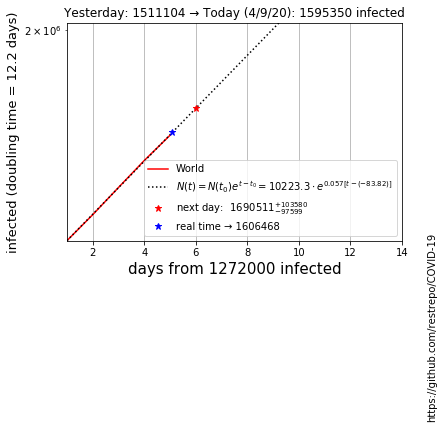

In [16]:
#for i in range(95):
if True:
    extra_days=10
    max_forecast=2000000
    tunep0_3=10
    exp_start=74

    plt.close()
    #Download real time data
    today=pd.read_html(url,skiprows=[0])[0]
    #Save a copy
    for c in ['Confirmed Case','Death','Recover']:
        today[c]=today[c].fillna(0).astype(int)
    today.to_csv('world.csv',index=False)    
    #Sum 'Confirmed Case' and get real time point (rtx,rty)
    tdy=today.columns[1].split('/')
    rtx=None
    try:
        dt=datetime.datetime(
            int(tdy[0].split(' ')[-1]),
            int(tdy[1]),
            int(tdy[2].split(' ')[0]),
            int(tdy[2].split(' ')[-1].split(':')[0]),
            int(tdy[2].split(' ')[-1].split(':')[1])
        )
    except:
        dt=datetime.datetime.strptime(dc[-1],'%m/%d/%y')
        
    if dt.strftime('%-m/%-d/%y')!=dc[-1]:
        rtx=int(dt.strftime('%H'))/24
        rty=int(today['Confirmed Case'].sum())
    date_start=dc[exp_start]#dc[0]
    date_end=dc[-1]
    ylinlog='log'
    y=index_field(cva,"Country/Region",filter=
                date_range(date_start=date_start,date_end=date_end)
                ).sum().to_list()
    x=range(1,len(y)+1)
    x=list(x)

    xx=range(x[0],x[-1]+extra_days)
    exp_fit = opt.curve_fit(exponential_model,x,y,p0=[1,0.4,tunep0_3])
    try:
        Δb=np.sqrt(exp_fit[1][1,1])
    except:
        Δb=0
    if min(y)>0:
        ymin=min(y)
    else:
        ymin=1

    #Doubling time
    N0=exp_fit[0][0];g=exp_fit[0][1];t0=exp_fit[0][2]
    if exponential_model(t0,N0,g,t0)==N0:
        Td=np.log(2)/g
    else:
        Td=None
    if Td:
        dt=re.sub('\.0\s',' ', '(doubling time = {} days)'.format(Td.round(1)
            ))
        texmodel='N(t)=N(t_0)e^{t-t_0}='
    else:
        texmodel=''
        dt=''

    #Prediction next day
    exp_fit_world=exp_fit[0].copy()
    exponential_model_world=lambda x: exponential_model(x, exp_fit_world[0],exp_fit_world[1],exp_fit_world[2]  )
    infc=exponential_model_world(x[-1]+1  )
    pinfc=exponential_model(x[-1]+1, exp_fit_world[0],exp_fit_world[1]+Δb,exp_fit_world[2]  )-infc
    minfc=infc-exponential_model(x[-1]+1, exp_fit_world[0],exp_fit_world[1]-Δb,exp_fit_world[2]  )
    next_day=r'next day:  $%d^{+%d}_{-%d}$' %(
                            int( infc ),int( pinfc ),int( minfc )  )


    #ax = plt.subplot()
    #plt.figure( figsize=(8,5) )
    plt.plot(x,y,'r-',label='World')
    plt.plot(xx,
            exponential_model(xx,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]),
            'k:',
            label=r'$%s%g\cdot e^{%g[t-(%g)]}$' %(texmodel,
                                                exp_fit[0][0].round(2),
                                                exp_fit[0][1].round(3),
                                                exp_fit[0][2].round(2)) )
    plt.plot(x[-1]+1,infc,'r*',markersize=7,
            label=next_day
            )
    if rtx is not None:
        plt.plot(x[-1]+rtx,rty,'b*',markersize=7,
            label='real time → {}'.format(rty)
            )

    

    plt.legend(loc='lower right')#(0.8,0.1),fontsize=15)
    plt.xscale('linear')
    plt.yscale(ylinlog)
    plt.xlabel('days from {} infected'.format(round(ymin,-3)),size=15)
    plt.ylabel('infected '+dt,size=13 )
    plt.title('Yesterday: {} → Today ({}): {} infected'.format(y[-2],dmax,y[-1]))
    if ylinlog=='linear':
        xmax=x[-1]+2
        ymax=y[-1]+infc+Δb
    else:
        xmax=xx[-1]
        ymax=max_forecast+30000

    plt.text(xmax+1,ymin,'https://github.com/restrepo/COVID-19',rotation=90)        
    plt.xlim(xx[0],xmax)
    plt.ylim(ymin,ymax)
    plt.grid()
    print('last  update: {} at {}'.format(today['Confirmed Case'].sum(),today.columns[1]))
    plt.savefig('world.png')
    plt.savefig('world.pdf')
    
    if os.getcwd()=='/content':    
        !cp world.png ../gdrive/My\ Drive/
        !cp world.pdf ../gdrive/My\ Drive/
    else:
        !git commit -am 'automatic update' 2>/dev/null > /dev/null
        !git push origin master 2>/dev/null > /dev/null
    #time.sleep(wait_minutes*60)

In [ ]:
s=time.time()
#time.sleep(wait_minutes*60)
print(time.time()-s)

In [ ]:
start_day='3/12/20'
sp=dataframe_doubling(x,y,start_date=start_day,final_date=dmax)

In [ ]:
plt.plot(sp['day'],sp['Td'],'k-')
plt.plot(sp['day'],sp['Td'],'r.')
plt.title('Example: A DT of 2 means that infections double every 2 days')
plt.xlabel('days from {}'.format(
    datetime.datetime.strptime(start_day,"%m/%d/%y").strftime("%B %-d, %Y")
  ))
plt.ylabel('Doubling time (DT) in units of days')
plt.savefig('doublingtime.png')

In [ ]:
γ=1./4.1 # 1/days #More conservative value
μ=1/(70*365) #1/days #Does not matter at all!
plt.plot(sp['day'],RO(sp['Td'].values,γ,μ   ),'ro' )
plt.plot(sp['day'],RO(sp['Td'].values,γ,μ   ) )
plt.xlabel('days',size=15)
plt.ylabel('RO',size=15)

In [ ]:
today['Confirmed Case'].sum()

In [ ]:
today.columns[1]

In [ ]:
today.groupby('Nation').sum().loc['COLOMBIA']

In [ ]:
today.groupby('Nation').sum().loc['AUSTRALIA']

In [ ]:
today.groupby('Nation').sum().loc['BRAZIL']